# Homework 4 (Ibotta Products)

In [9]:
# import analysis packages
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, Flatten, SimpleRNN, TextVectorization
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

### Data Preprocessing

In [3]:
# read data from .csv files
trainDF = pd.read_csv('./ibotta_train.csv')
testDF = pd.read_csv('./ibotta_test.csv')

# combine data sets for preprocessing
trainDF['origin'] = 'train'
testDF['origin'] = 'test'
fullDF = pd.concat([trainDF, testDF])

In [4]:
# text cleaning
fullDF['Brand_name'].where(-fullDF['Brand_name'].isna(), '', inplace = True)
fullDF['Brand_name'] = fullDF['Brand_name'].apply(lambda x: x.lower().replace("'", "").replace(",", "").replace(":", "").replace("-", "").replace(".", ""))
fullDF['Name'] = fullDF['Name'].apply(lambda x: x.lower().replace("'", "").replace(",", "").replace(":", "").replace("-", "").replace(".", ""))

# combine brand and name fields
fullDF['brandAlready'] = fullDF.apply(lambda x: x['Name'].find(x['Brand_name']), axis = 1)
fullDF.loc[fullDF.brandAlready == -1, 'Name'] = fullDF.loc[fullDF.brandAlready == -1, 'Brand_name'] + \
    ' ' + fullDF.loc[fullDF.brandAlready == -1, 'Name']
fullDF.drop('brandAlready', axis = 1, inplace = True)

In [5]:
# seed random seed
random.seed(542023)

# split data
trainDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'train'].drop('origin', axis = 1))
validIdx = random.sample(list(trainDF['Id'] - 1), 1000)
validDF = trainDF.loc[validIdx]
trainDF = trainDF.loc[trainDF['Id'].apply(lambda x: x not in validIdx)]
testDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'test'].drop(['origin', 'Category'], axis = 1))

# check dimensions of data
display(trainDF.shape)
display(validDF.shape)
display(testDF.shape)

# check data types
display(trainDF.info())

# peek at data
display(trainDF.head())

(7000, 5)

(1000, 5)

(1999, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          7000 non-null   int64  
 1   Name        7000 non-null   object 
 2   Brand_name  7000 non-null   object 
 3   Category    7000 non-null   object 
 4   Cat_code    7000 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 328.1+ KB


None

,Id,Name,Brand_name,Category,Cat_code
0,1,4c homestyle parmesan grated cheese 6 oz,4c,Dairy,2.0
1,2,4c 100% natural parmesan cheese 6 oz,,Dairy,2.0
2,3,4c parmesan & romano cheese grated,4c,Dairy,2.0
3,4,advance fast fixin country fried steaks with g...,fast fixin,Frozen Foods,3.0
5,6,borden dairy company borden natural medium che...,borden dairy company,Dairy,2.0


### Text Vectorization

In [6]:
# find total number of unique words
unique_words = np.unique(np.array(' '.join(np.array(fullDF['Name'])).split(' ')))
max_length = len(unique_words)

# initialize empty dataframe
wordBag = pd.DataFrame(np.zeros((len(fullDF), max_length)), 
                       columns = unique_words)

# loop through product names
for i, productName in enumerate(fullDF['Name'].apply(lambda x: x.split(' '))):
    # loop through words in name
    for word in productName:
        # identify word presence
        wordBag.loc[i, word] = 1

# peek at bag of words
display(wordBag.head())

# split word bag
trainDFwordBag = wordBag.loc[0:7999]
validDFwordBag = trainDFwordBag.loc[validIdx]
trainDFwordBag = trainDFwordBag.loc[pd.Series(trainDFwordBag.index).apply(lambda x: x not in validIdx)]
testDFwordBag = wordBag.loc[8000:9999]

# check dimensions of data
display(trainDFwordBag.shape)
display(validDFwordBag.shape)
display(testDFwordBag.shape)

,,%,&,(101731),(12,(175,(18,(187,(4,(4th,...,zings,zip,zippak¨∆,zipçƒîpak,ziti,zoi,zucchini,|,çƒî,çƒï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(7000, 4977)

(1000, 4977)

(1999, 4977)

In [27]:
# tag data with iterable object
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(fullDF['Name'].apply(lambda x: x.split(' ')))]

# doc2vec vectorization function
def doc2vecGen(size):
    # train doc2vec tokenizer
    tokenizer = Doc2Vec(tagged_data, vector_size = size, min_count = 1, epochs = 100)
    tokenizer.build_vocab(list(tagged_data))
    tokenizer.train(list(tagged_data), 
                    total_examples = tokenizer.corpus_count, 
                    epochs = tokenizer.epochs)
    
    # vectorize text data
    doc2vecDF = fullDF['Name'].apply(lambda x: tokenizer.infer_vector(x.split(' ')))
    doc2vecDF = pd.DataFrame(np.array(doc2vecDF))[0].apply(pd.Series)

    # split vectorized data
    trainDFdoc2vec = doc2vecDF.loc[0:7999]
    validDFdoc2vec = doc2vecDF.loc[validIdx]
    trainDFdoc2vec = trainDFdoc2vec.loc[pd.Series(trainDFdoc2vec.index).apply(lambda x: x not in validIdx)]
    testDFdoc2vec = doc2vecDF.loc[8000:9999]

    return(trainDFdoc2vec, validDFdoc2vec, testDFdoc2vec)

# generate vectorized data
trainDFdoc2vecMAX, validDFdoc2vecMAX, testDFdoc2vecMAX = doc2vecGen(max_length)
trainDFdoc2vec1000, validDFdoc2vec1000, testDFdoc2vec1000 = doc2vecGen(1000)
trainDFdoc2vec500, validDFdoc2vec500, testDFdoc2vec500 = doc2vecGen(500)
trainDFdoc2vec100, validDFdoc2vec100, testDFdoc2vec100 = doc2vecGen(100)

In [7]:
# keras tokenizer function
def textVecGen(size):
    # train keras tokenizer
    tokenizer = TextVectorization(output_sequence_length = size)
    tokenizer.adapt(fullDF['Name'])

    # vectorize data
    textVecDF = pd.DataFrame(tokenizer(fullDF['Name']))
    
    # split vectorized data
    trainDFtextVec = textVecDF.loc[0:7999]
    validDFtextVec = trainDFtextVec.loc[validIdx]
    trainDFtextVec = trainDFtextVec.loc[pd.Series(trainDFtextVec.index).apply(lambda x: x not in validIdx)]
    testDFtextVec = textVecDF.loc[8000:9999]

    return(trainDFtextVec, validDFtextVec, testDFtextVec)

# generate vectorized data
trainDFtextVecMAX, validDFtextVecMAX, testDFtextVecMAX = textVecGen(max_length)
trainDFtextVec1000, validDFtextVec1000, testDFtextVec1000 = textVecGen(1000)
trainDFtextVec500, validDFtextVec500, testDFtextVec500 = textVecGen(500)
trainDFtextVec100, validDFtextVec100, testDFtextVec100 = textVecGen(100)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-05 08:39:27.978391: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Model Fitting

In [16]:
# model evaluation function
def EvaluateModel(model, X_train):
    # set random seeds
    np.random.seed(542023)
    tf.random.set_seed(542023)

    # print model summary
    try:
        model.summary()
    except:
        pass

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    # define early stopping criterion
    early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3)

    # train deep learning model
    trained = model.fit(X_train,
                        to_categorical(trainDF['Cat_code']),
                        epochs = 100,
                        batch_size = 32,
                        callbacks = early,
                        validation_split = 0.15,
                        verbose = 1)
    
    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # final validation accuracy
    display(f"Internal validation accuracy: {round(val_acc[-1] * 100, 2)}%")

    # plot training accuracy
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))
    ax1.plot(epochs, acc, 'bo', label = 'Training acc')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation acc')
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    ax1.legend()
    ax2.plot(epochs, loss, 'bo', label = 'Training loss')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation loss')
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    ax2.legend()
    fig.suptitle('Evaluation Metrics')

### Bag of Words

Epoch 1/100
186/186 [==============================] - 5s 22ms/step - loss: 0.7371 - accuracy: 0.7803 - val_loss: 0.6822 - val_accuracy: 0.8295
Epoch 2/100
186/186 [==============================] - 4s 21ms/step - loss: 0.3237 - accuracy: 0.9303 - val_loss: 0.6176 - val_accuracy: 0.8486
Epoch 3/100
186/186 [==============================] - 4s 20ms/step - loss: 0.2585 - accuracy: 0.9424 - val_loss: 0.6703 - val_accuracy: 0.8505
Epoch 4/100
186/186 [==============================] - 4s 19ms/step - loss: 0.2217 - accuracy: 0.9516 - val_loss: 0.6723 - val_accuracy: 0.8467
Epoch 5/100
186/186 [==============================] - 4s 19ms/step - loss: 0.1874 - accuracy: 0.9568 - val_loss: 0.7173 - val_accuracy: 0.8429


'Internal validation accuracy: 84.29%'

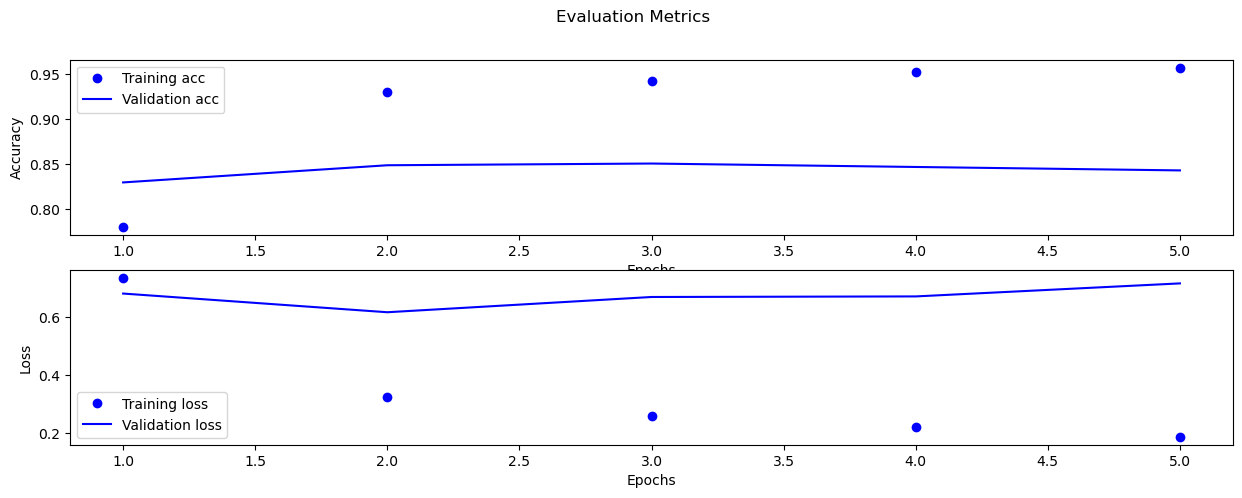

In [124]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)


# set random seeds
np.random.seed(542023)
tf.random.set_seed(542023)

 # compile model
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
    
# define early stopping criterion
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3)

# train deep learning model on full training set
trained = model.fit(trainDFwordBag,
                    to_categorical(trainDF['Cat_code']),
                    epochs = 100,
                    batch_size = 32,
                    callbacks = early,
                    verbose = 1)

# predict on validation set
pred = model.predict(validDFwordBag)

# compute final validation accuracy
# display(f"Validation accuracy: {round(val_acc[-1] * 100, 2)}%")

Epoch 1/100
186/186 [==============================] - 10s 51ms/step - loss: 0.7905 - accuracy: 0.7563 - val_loss: 0.7460 - val_accuracy: 0.8219
Epoch 2/100
186/186 [==============================] - 9s 48ms/step - loss: 0.3761 - accuracy: 0.9262 - val_loss: 0.7286 - val_accuracy: 0.8105
Epoch 3/100
186/186 [==============================] - 9s 51ms/step - loss: 0.2989 - accuracy: 0.9412 - val_loss: 0.8684 - val_accuracy: 0.8476
Epoch 4/100
186/186 [==============================] - 9s 49ms/step - loss: 0.2575 - accuracy: 0.9504 - val_loss: 0.7191 - val_accuracy: 0.8524
Epoch 5/100
186/186 [==============================] - 9s 48ms/step - loss: 0.2272 - accuracy: 0.9539 - val_loss: 0.7258 - val_accuracy: 0.8400
Epoch 6/100
186/186 [==============================] - 10s 53ms/step - loss: 0.2017 - accuracy: 0.9592 - val_loss: 0.7683 - val_accuracy: 0.8448
Epoch 7/100
186/186 [==============================] - 9s 48ms/step - loss: 0.1687 - accuracy: 0.9657 - val_loss: 0.8257 - val_accurac

'Internal validation accuracy: 82.48%'

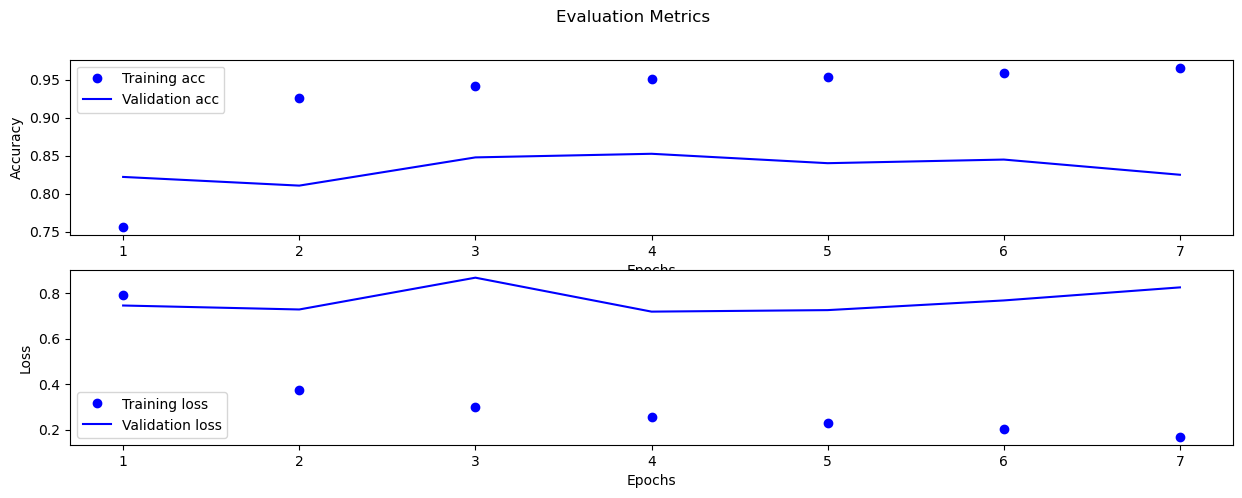

In [121]:
# define model architecture
model = Sequential([
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)

Epoch 1/100
186/186 [==============================] - 13s 65ms/step - loss: 1.6037 - accuracy: 0.6629 - val_loss: 1.1255 - val_accuracy: 0.7714
Epoch 2/100
186/186 [==============================] - 8s 45ms/step - loss: 0.7745 - accuracy: 0.8686 - val_loss: 1.0813 - val_accuracy: 0.7390
Epoch 3/100
186/186 [==============================] - 8s 45ms/step - loss: 0.6545 - accuracy: 0.8855 - val_loss: 0.8440 - val_accuracy: 0.8295
Epoch 4/100
186/186 [==============================] - 8s 45ms/step - loss: 0.5996 - accuracy: 0.8926 - val_loss: 0.7922 - val_accuracy: 0.8362
Epoch 5/100
186/186 [==============================] - 8s 44ms/step - loss: 0.5666 - accuracy: 0.8956 - val_loss: 0.8119 - val_accuracy: 0.8171
Epoch 6/100
186/186 [==============================] - 8s 44ms/step - loss: 0.5412 - accuracy: 0.8987 - val_loss: 0.7275 - val_accuracy: 0.8429
Epoch 7/100
186/186 [==============================] - 8s 44ms/step - loss: 0.5154 - accuracy: 0.9047 - val_loss: 0.7955 - val_accuracy

'Internal validation accuracy: 82.57%'

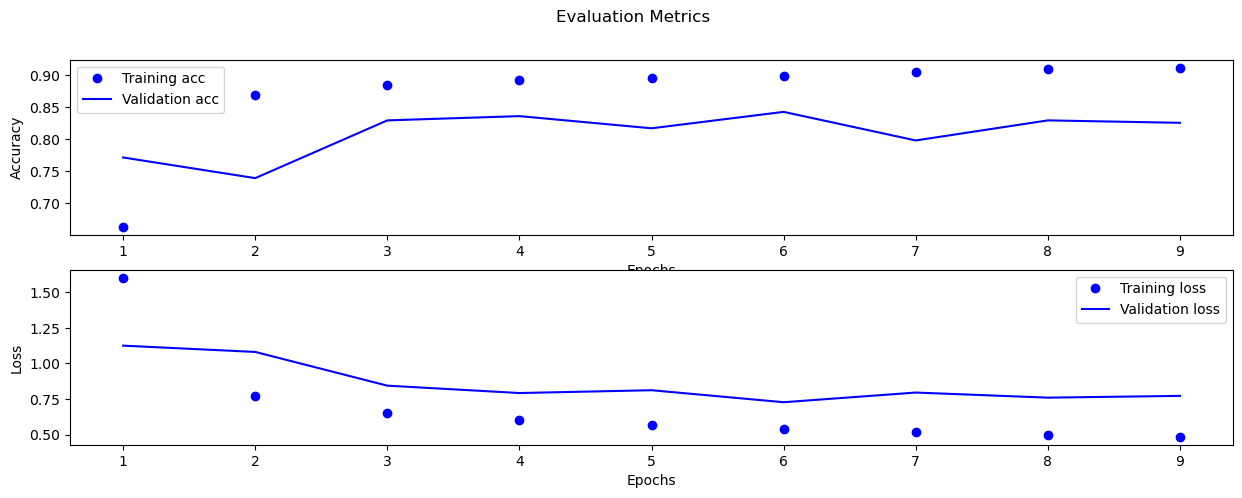

In [122]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFwordBag)

### Doc2Vec

Epoch 1/100
186/186 [==============================] - 5s 22ms/step - loss: 1.5433 - accuracy: 0.4291 - val_loss: 1.6370 - val_accuracy: 0.4390
Epoch 2/100
186/186 [==============================] - 4s 19ms/step - loss: 1.2328 - accuracy: 0.5746 - val_loss: 1.5036 - val_accuracy: 0.4876
Epoch 3/100
186/186 [==============================] - 4s 19ms/step - loss: 1.0324 - accuracy: 0.6501 - val_loss: 1.3554 - val_accuracy: 0.5629
Epoch 4/100
186/186 [==============================] - 4s 19ms/step - loss: 0.8650 - accuracy: 0.7119 - val_loss: 1.5008 - val_accuracy: 0.5581
Epoch 5/100
186/186 [==============================] - 4s 19ms/step - loss: 0.7047 - accuracy: 0.7618 - val_loss: 1.6419 - val_accuracy: 0.5286
Epoch 6/100
186/186 [==============================] - 4s 19ms/step - loss: 0.5886 - accuracy: 0.8050 - val_loss: 1.5742 - val_accuracy: 0.5810


'Internal validation accuracy: 58.1%'

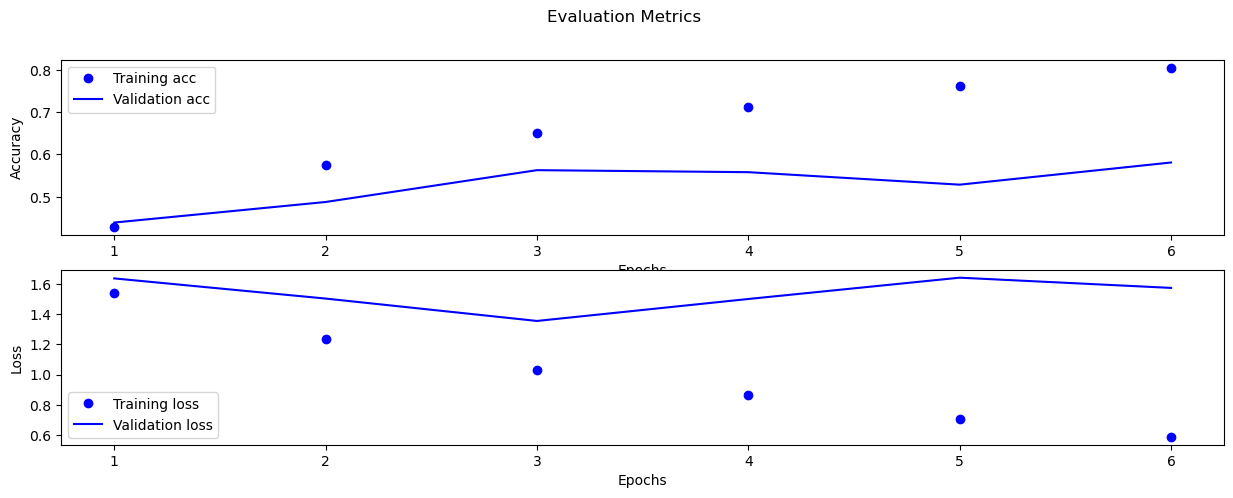

In [127]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vecMAX)

Epoch 1/100
186/186 [==============================] - 10s 47ms/step - loss: 2.3692 - accuracy: 0.2877 - val_loss: 1.9636 - val_accuracy: 0.2467
Epoch 2/100
186/186 [==============================] - 8s 45ms/step - loss: 1.7701 - accuracy: 0.2978 - val_loss: 1.8585 - val_accuracy: 0.2600
Epoch 3/100
186/186 [==============================] - 8s 44ms/step - loss: 1.7126 - accuracy: 0.3338 - val_loss: 1.8018 - val_accuracy: 0.3210
Epoch 4/100
186/186 [==============================] - 8s 44ms/step - loss: 1.6713 - accuracy: 0.3429 - val_loss: 1.8171 - val_accuracy: 0.3057
Epoch 5/100
186/186 [==============================] - 8s 44ms/step - loss: 1.6362 - accuracy: 0.3689 - val_loss: 1.7809 - val_accuracy: 0.3295
Epoch 6/100
186/186 [==============================] - 8s 44ms/step - loss: 1.6130 - accuracy: 0.3837 - val_loss: 1.8063 - val_accuracy: 0.3276
Epoch 7/100
186/186 [==============================] - 8s 44ms/step - loss: 1.6032 - accuracy: 0.3894 - val_loss: 1.8345 - val_accuracy

'Internal validation accuracy: 34.76%'

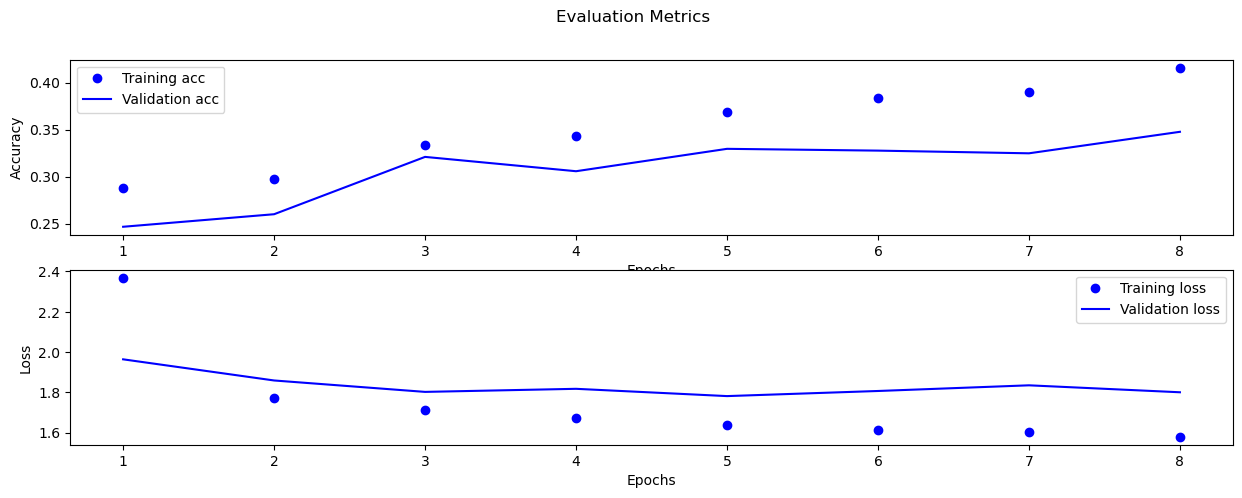

In [126]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vecMAX)

Epoch 1/100
186/186 [==============================] - 5s 21ms/step - loss: 1.5455 - accuracy: 0.4319 - val_loss: 1.5153 - val_accuracy: 0.4762
Epoch 2/100
186/186 [==============================] - 3s 19ms/step - loss: 1.1916 - accuracy: 0.5961 - val_loss: 1.4829 - val_accuracy: 0.4971
Epoch 3/100
186/186 [==============================] - 3s 19ms/step - loss: 0.9818 - accuracy: 0.6704 - val_loss: 1.2601 - val_accuracy: 0.6067
Epoch 4/100
186/186 [==============================] - 3s 17ms/step - loss: 0.8145 - accuracy: 0.7272 - val_loss: 1.3234 - val_accuracy: 0.6000
Epoch 5/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6588 - accuracy: 0.7783 - val_loss: 1.5687 - val_accuracy: 0.5181
Epoch 6/100
186/186 [==============================] - 3s 18ms/step - loss: 0.5489 - accuracy: 0.8173 - val_loss: 1.4913 - val_accuracy: 0.6219


'Internal validation accuracy: 62.19%'

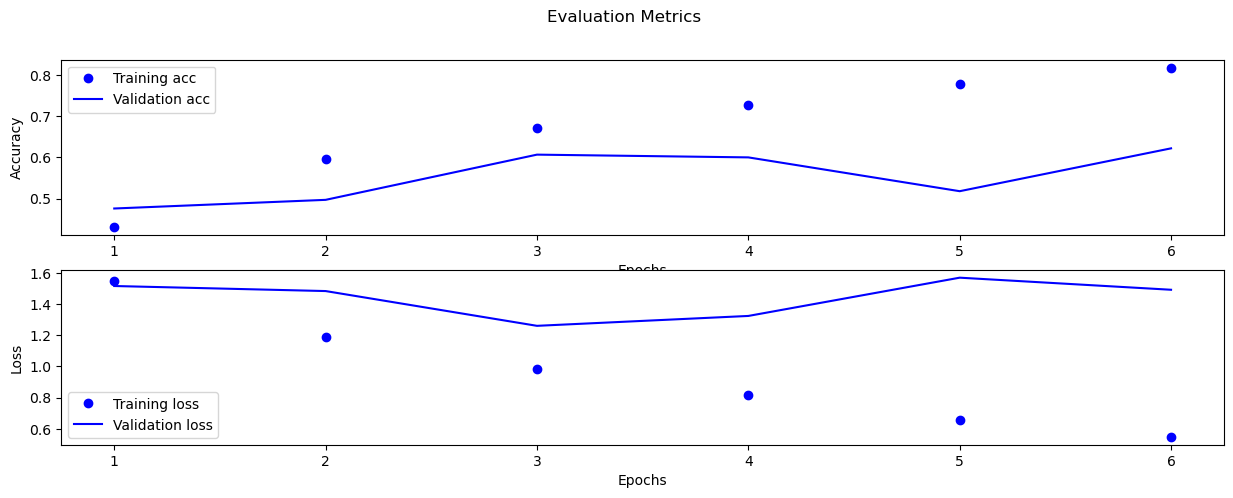

In [128]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Epoch 1/100
186/186 [==============================] - 7s 32ms/step - loss: 2.3503 - accuracy: 0.3259 - val_loss: 1.9617 - val_accuracy: 0.3038
Epoch 2/100
186/186 [==============================] - 5s 29ms/step - loss: 1.7160 - accuracy: 0.4294 - val_loss: 1.8771 - val_accuracy: 0.3410
Epoch 3/100
186/186 [==============================] - 5s 28ms/step - loss: 1.5984 - accuracy: 0.4697 - val_loss: 1.7321 - val_accuracy: 0.4371
Epoch 4/100
186/186 [==============================] - 5s 29ms/step - loss: 1.5225 - accuracy: 0.5050 - val_loss: 1.7173 - val_accuracy: 0.4362
Epoch 5/100
186/186 [==============================] - 5s 28ms/step - loss: 1.4633 - accuracy: 0.5321 - val_loss: 1.6960 - val_accuracy: 0.4419
Epoch 6/100
186/186 [==============================] - 5s 29ms/step - loss: 1.4125 - accuracy: 0.5545 - val_loss: 1.6848 - val_accuracy: 0.4638
Epoch 7/100
186/186 [==============================] - 5s 28ms/step - loss: 1.3669 - accuracy: 0.5748 - val_loss: 1.6622 - val_accuracy:

'Internal validation accuracy: 50.0%'

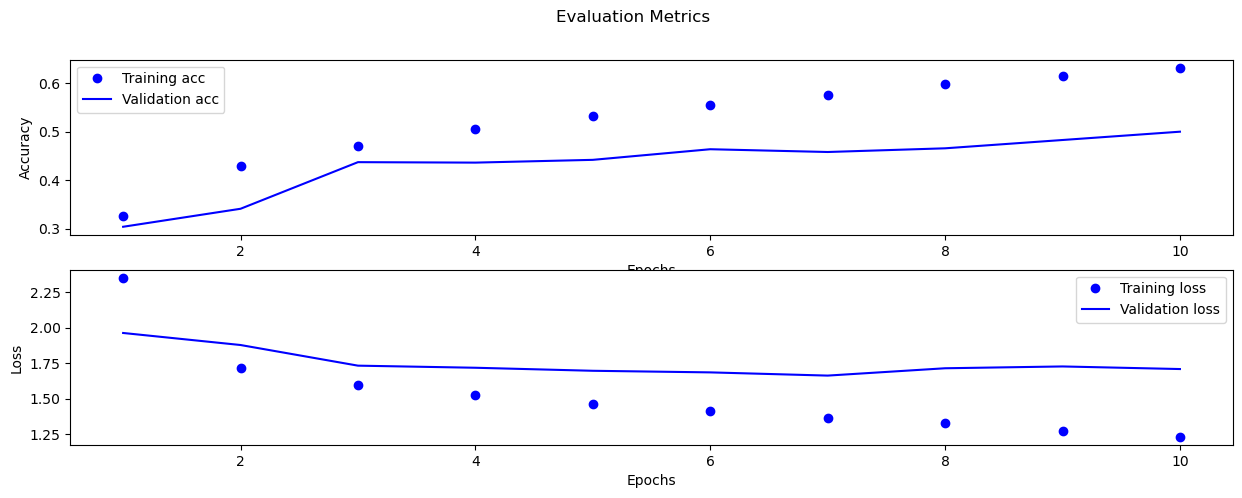

In [129]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Epoch 1/100
186/186 [==============================] - 5s 20ms/step - loss: 1.5362 - accuracy: 0.4385 - val_loss: 1.5558 - val_accuracy: 0.4695
Epoch 2/100
186/186 [==============================] - 4s 19ms/step - loss: 1.1872 - accuracy: 0.5966 - val_loss: 1.5455 - val_accuracy: 0.4800
Epoch 3/100
186/186 [==============================] - 3s 18ms/step - loss: 0.9725 - accuracy: 0.6787 - val_loss: 1.3405 - val_accuracy: 0.5638
Epoch 4/100
186/186 [==============================] - 3s 19ms/step - loss: 0.7932 - accuracy: 0.7412 - val_loss: 1.4179 - val_accuracy: 0.5648
Epoch 5/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6375 - accuracy: 0.7854 - val_loss: 1.5232 - val_accuracy: 0.5362
Epoch 6/100
186/186 [==============================] - 3s 17ms/step - loss: 0.5244 - accuracy: 0.8255 - val_loss: 1.6801 - val_accuracy: 0.5657


'Internal validation accuracy: 56.57%'

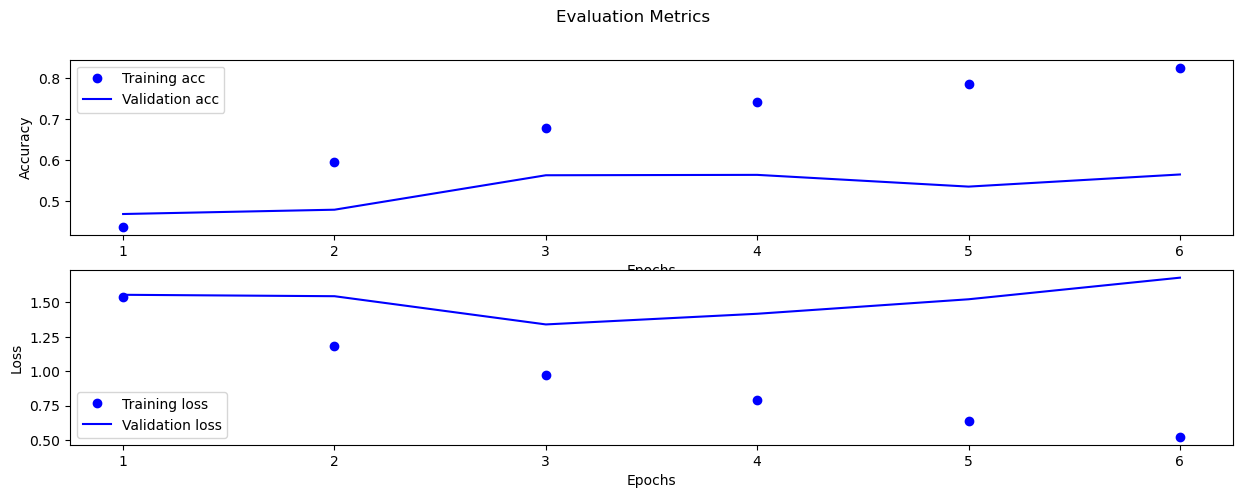

In [130]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec500)

Epoch 1/100
186/186 [==============================] - 7s 29ms/step - loss: 2.2874 - accuracy: 0.2916 - val_loss: 1.9926 - val_accuracy: 0.2562
Epoch 2/100
186/186 [==============================] - 5s 28ms/step - loss: 1.7340 - accuracy: 0.3323 - val_loss: 1.8293 - val_accuracy: 0.2990
Epoch 3/100
186/186 [==============================] - 5s 28ms/step - loss: 1.6409 - accuracy: 0.3497 - val_loss: 1.7740 - val_accuracy: 0.3248
Epoch 4/100
186/186 [==============================] - 5s 26ms/step - loss: 1.5986 - accuracy: 0.3592 - val_loss: 1.8497 - val_accuracy: 0.3048
Epoch 5/100
186/186 [==============================] - 5s 26ms/step - loss: 1.5593 - accuracy: 0.3921 - val_loss: 1.7785 - val_accuracy: 0.3467
Epoch 6/100
186/186 [==============================] - 5s 26ms/step - loss: 1.5184 - accuracy: 0.4212 - val_loss: 1.8128 - val_accuracy: 0.3629


'Internal validation accuracy: 36.29%'

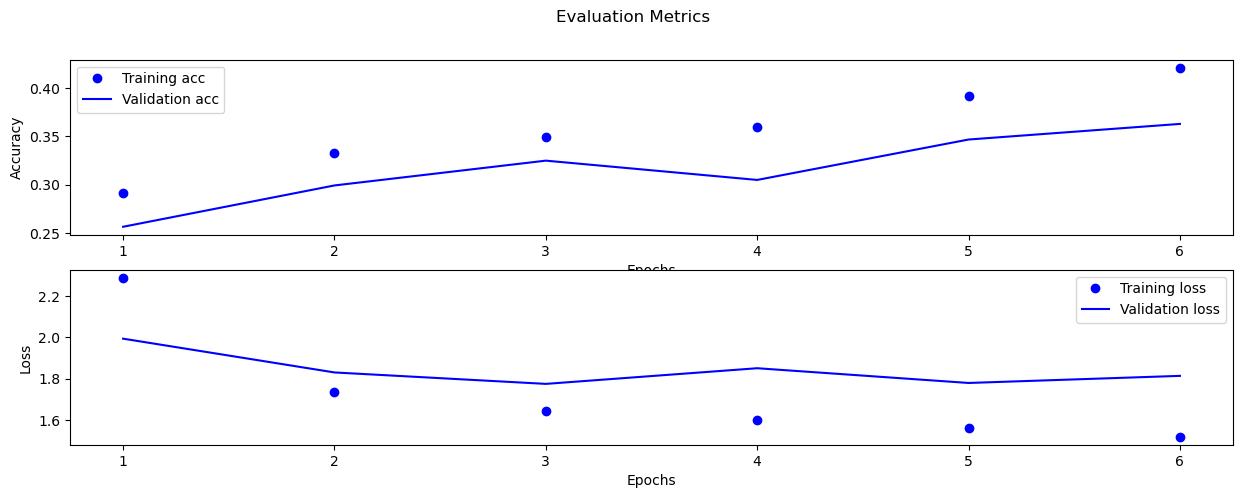

In [131]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec500)

Epoch 1/100
186/186 [==============================] - 4s 19ms/step - loss: 1.5767 - accuracy: 0.4237 - val_loss: 1.5578 - val_accuracy: 0.4371
Epoch 2/100
186/186 [==============================] - 3s 17ms/step - loss: 1.2539 - accuracy: 0.5691 - val_loss: 1.4759 - val_accuracy: 0.5048
Epoch 3/100
186/186 [==============================] - 3s 17ms/step - loss: 1.0452 - accuracy: 0.6418 - val_loss: 1.3465 - val_accuracy: 0.5524
Epoch 4/100
186/186 [==============================] - 3s 17ms/step - loss: 0.8855 - accuracy: 0.7029 - val_loss: 1.4186 - val_accuracy: 0.5581
Epoch 5/100
186/186 [==============================] - 3s 17ms/step - loss: 0.7252 - accuracy: 0.7575 - val_loss: 1.5249 - val_accuracy: 0.5286
Epoch 6/100
186/186 [==============================] - 3s 17ms/step - loss: 0.5986 - accuracy: 0.8037 - val_loss: 1.5895 - val_accuracy: 0.5695


'Internal validation accuracy: 56.95%'

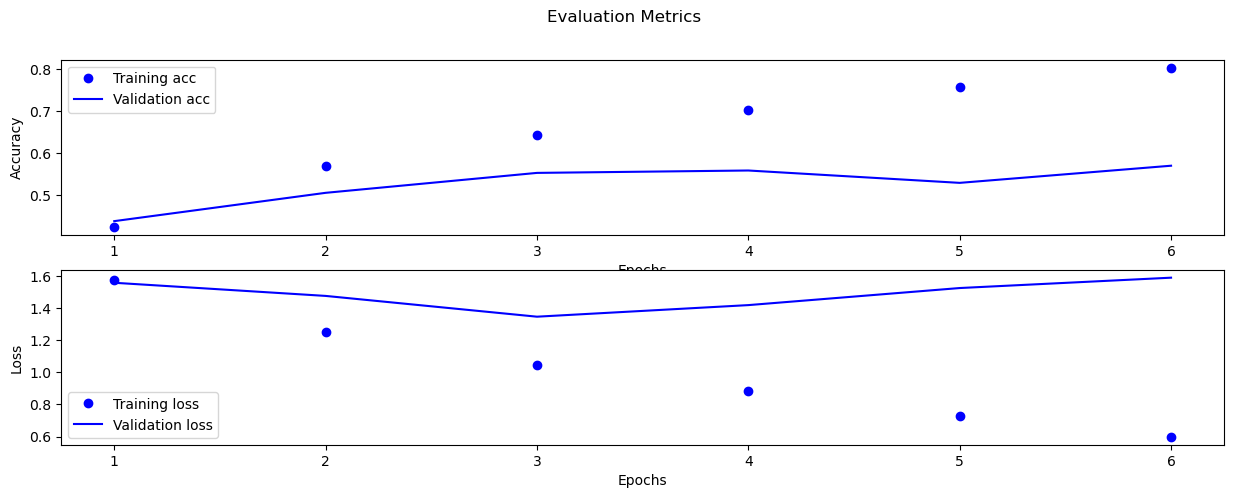

In [132]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

Epoch 1/100
186/186 [==============================] - 7s 30ms/step - loss: 2.1836 - accuracy: 0.3444 - val_loss: 1.9060 - val_accuracy: 0.3410
Epoch 2/100
186/186 [==============================] - 5s 26ms/step - loss: 1.6749 - accuracy: 0.4528 - val_loss: 1.7890 - val_accuracy: 0.3867
Epoch 3/100
186/186 [==============================] - 5s 25ms/step - loss: 1.5412 - accuracy: 0.5005 - val_loss: 1.7244 - val_accuracy: 0.4305
Epoch 4/100
186/186 [==============================] - 5s 26ms/step - loss: 1.4576 - accuracy: 0.5418 - val_loss: 1.7546 - val_accuracy: 0.4381
Epoch 5/100
186/186 [==============================] - 5s 25ms/step - loss: 1.3706 - accuracy: 0.5726 - val_loss: 1.6832 - val_accuracy: 0.4495
Epoch 6/100
186/186 [==============================] - 5s 25ms/step - loss: 1.2963 - accuracy: 0.6064 - val_loss: 1.7393 - val_accuracy: 0.4467
Epoch 7/100
186/186 [==============================] - 5s 26ms/step - loss: 1.2399 - accuracy: 0.6321 - val_loss: 1.6647 - val_accuracy:

'Internal validation accuracy: 48.57%'

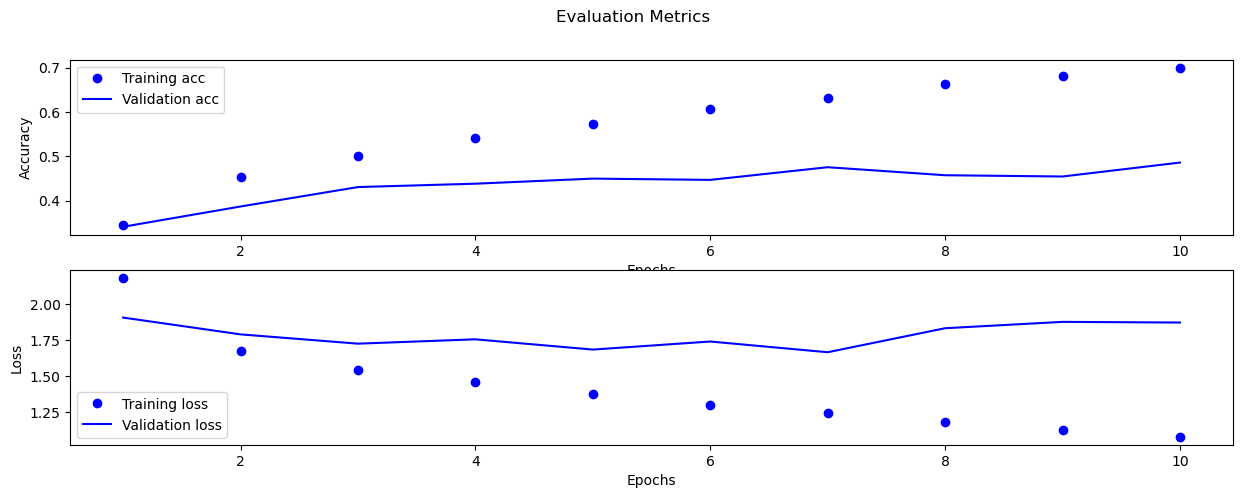

In [133]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

### Keras Vectorization

Epoch 1/100
186/186 [==============================] - 5s 24ms/step - loss: 3.4554 - accuracy: 0.2719 - val_loss: 2.1231 - val_accuracy: 0.2905
Epoch 2/100
186/186 [==============================] - 4s 21ms/step - loss: 1.9070 - accuracy: 0.3392 - val_loss: 1.9150 - val_accuracy: 0.3086
Epoch 3/100
186/186 [==============================] - 4s 21ms/step - loss: 1.8053 - accuracy: 0.3496 - val_loss: 1.8308 - val_accuracy: 0.3276
Epoch 4/100
186/186 [==============================] - 4s 20ms/step - loss: 1.7695 - accuracy: 0.3703 - val_loss: 1.8586 - val_accuracy: 0.3152
Epoch 5/100
186/186 [==============================] - 4s 19ms/step - loss: 1.7411 - accuracy: 0.3674 - val_loss: 1.8495 - val_accuracy: 0.2943
Epoch 6/100
186/186 [==============================] - 4s 20ms/step - loss: 1.7204 - accuracy: 0.3734 - val_loss: 1.8216 - val_accuracy: 0.3048
Epoch 7/100
186/186 [==============================] - 4s 20ms/step - loss: 1.7132 - accuracy: 0.3706 - val_loss: 1.8389 - val_accuracy:

'Internal validation accuracy: 30.76%'

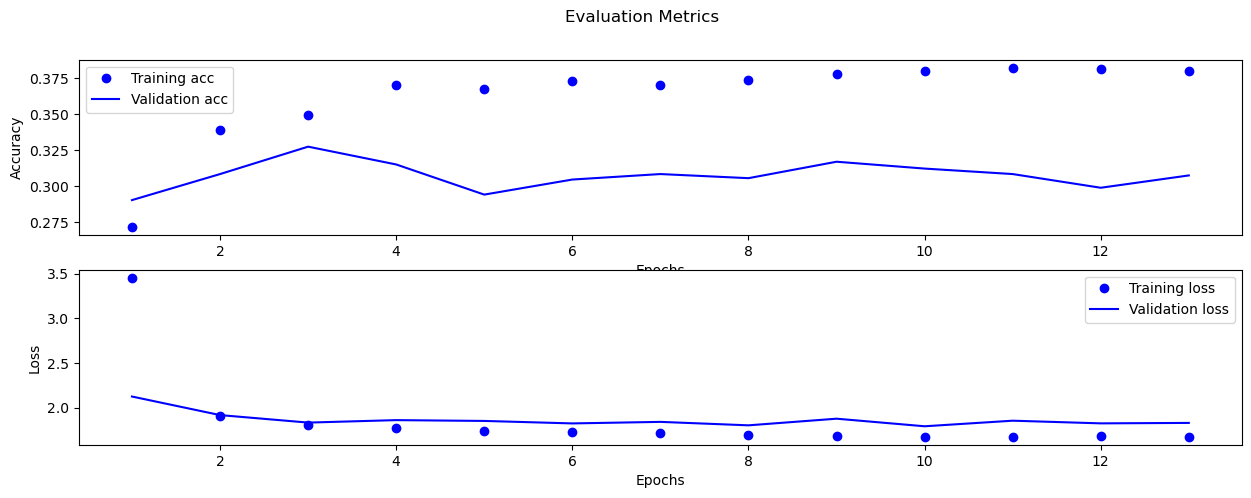

In [134]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVecMAX)

Epoch 1/100
186/186 [==============================] - 10s 50ms/step - loss: 6.9009 - accuracy: 0.2845 - val_loss: 2.8173 - val_accuracy: 0.2714
Epoch 2/100
186/186 [==============================] - 9s 48ms/step - loss: 2.2034 - accuracy: 0.3397 - val_loss: 2.0229 - val_accuracy: 0.2886
Epoch 3/100
186/186 [==============================] - 9s 49ms/step - loss: 1.8436 - accuracy: 0.3550 - val_loss: 1.8490 - val_accuracy: 0.3162
Epoch 4/100
186/186 [==============================] - 9s 48ms/step - loss: 1.7776 - accuracy: 0.3679 - val_loss: 1.8597 - val_accuracy: 0.2905
Epoch 5/100
186/186 [==============================] - 9s 46ms/step - loss: 1.7353 - accuracy: 0.3718 - val_loss: 1.8547 - val_accuracy: 0.3124
Epoch 6/100
186/186 [==============================] - 9s 46ms/step - loss: 1.7290 - accuracy: 0.3672 - val_loss: 1.8376 - val_accuracy: 0.3143
Epoch 7/100
186/186 [==============================] - 9s 49ms/step - loss: 1.7117 - accuracy: 0.3734 - val_loss: 1.8222 - val_accuracy

'Internal validation accuracy: 31.9%'

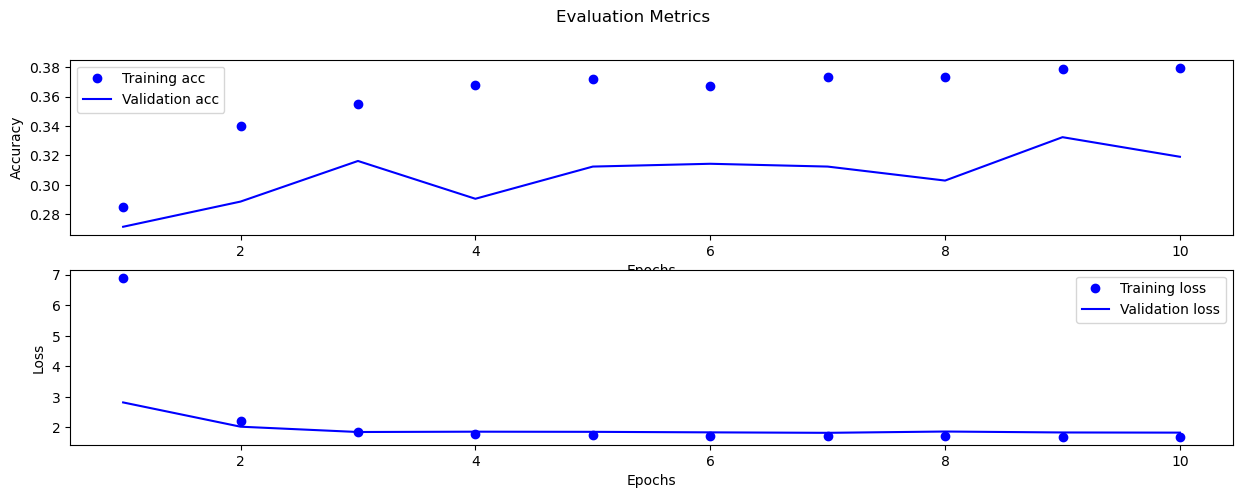

In [135]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVecMAX)

Epoch 1/100
186/186 [==============================] - 4s 21ms/step - loss: 4.9391 - accuracy: 0.2655 - val_loss: 1.9486 - val_accuracy: 0.2457
Epoch 2/100
186/186 [==============================] - 3s 19ms/step - loss: 1.8754 - accuracy: 0.3002 - val_loss: 1.8790 - val_accuracy: 0.2467
Epoch 3/100
186/186 [==============================] - 3s 18ms/step - loss: 1.8581 - accuracy: 0.2973 - val_loss: 1.8608 - val_accuracy: 0.2467
Epoch 4/100
186/186 [==============================] - 3s 18ms/step - loss: 1.8519 - accuracy: 0.3008 - val_loss: 1.8599 - val_accuracy: 0.2438
Epoch 5/100
186/186 [==============================] - 3s 18ms/step - loss: 1.8619 - accuracy: 0.2998 - val_loss: 1.8558 - val_accuracy: 0.2467
Epoch 6/100
186/186 [==============================] - 3s 18ms/step - loss: 1.7987 - accuracy: 0.3010 - val_loss: 1.8557 - val_accuracy: 0.2467
Epoch 7/100
186/186 [==============================] - 3s 18ms/step - loss: 1.7794 - accuracy: 0.2995 - val_loss: 1.8562 - val_accuracy:

'Internal validation accuracy: 24.67%'

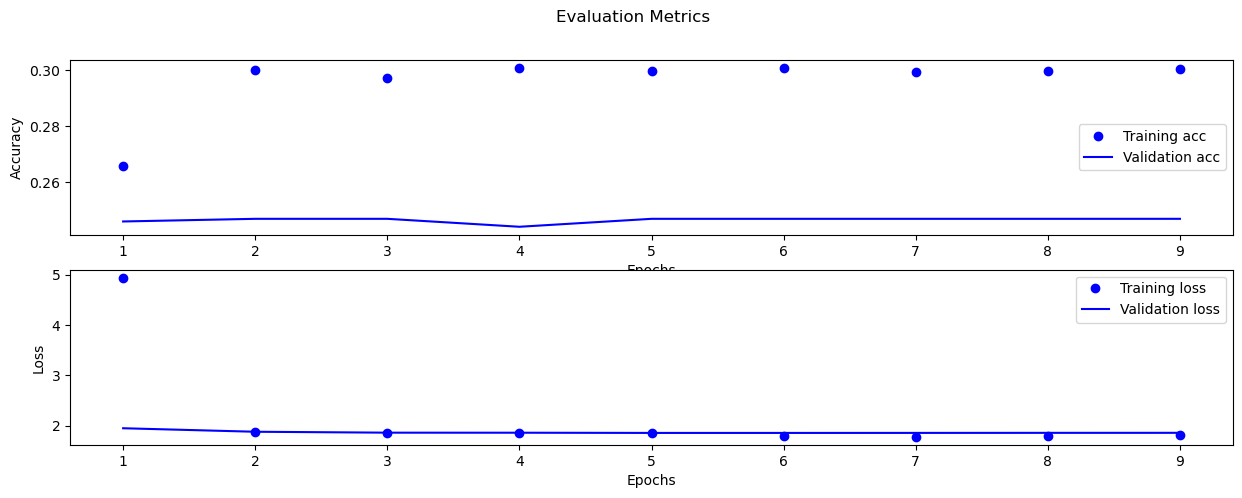

In [136]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Epoch 1/100
186/186 [==============================] - 7s 33ms/step - loss: 9.0361 - accuracy: 0.2597 - val_loss: 2.8876 - val_accuracy: 0.2943
Epoch 2/100
186/186 [==============================] - 5s 29ms/step - loss: 2.2645 - accuracy: 0.3267 - val_loss: 1.9930 - val_accuracy: 0.2886
Epoch 3/100
186/186 [==============================] - 5s 29ms/step - loss: 1.8513 - accuracy: 0.3582 - val_loss: 1.8593 - val_accuracy: 0.3219
Epoch 4/100
186/186 [==============================] - 5s 29ms/step - loss: 1.7629 - accuracy: 0.3706 - val_loss: 1.8393 - val_accuracy: 0.2924
Epoch 5/100
186/186 [==============================] - 5s 29ms/step - loss: 1.7313 - accuracy: 0.3709 - val_loss: 1.8974 - val_accuracy: 0.3200
Epoch 6/100
186/186 [==============================] - 5s 29ms/step - loss: 1.7288 - accuracy: 0.3745 - val_loss: 1.8262 - val_accuracy: 0.2914
Epoch 7/100
186/186 [==============================] - 5s 29ms/step - loss: 1.7161 - accuracy: 0.3677 - val_loss: 1.8216 - val_accuracy:

'Internal validation accuracy: 31.81%'

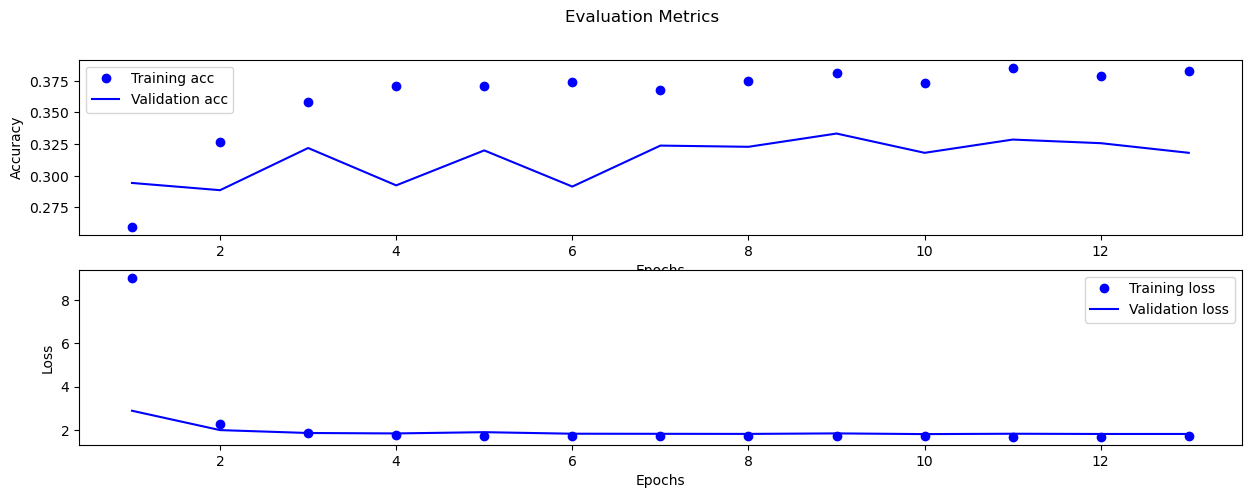

In [137]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Epoch 1/100
186/186 [==============================] - 4s 19ms/step - loss: 5.7615 - accuracy: 0.2447 - val_loss: 2.0304 - val_accuracy: 0.2867
Epoch 2/100
186/186 [==============================] - 3s 17ms/step - loss: 1.9298 - accuracy: 0.3008 - val_loss: 1.8891 - val_accuracy: 0.2467
Epoch 3/100
186/186 [==============================] - 3s 17ms/step - loss: 1.8663 - accuracy: 0.3025 - val_loss: 1.8736 - val_accuracy: 0.2476
Epoch 4/100
186/186 [==============================] - 3s 17ms/step - loss: 1.8075 - accuracy: 0.3020 - val_loss: 1.8643 - val_accuracy: 0.2467
Epoch 5/100
186/186 [==============================] - 3s 17ms/step - loss: 1.7835 - accuracy: 0.3010 - val_loss: 1.8539 - val_accuracy: 0.2467
Epoch 6/100
186/186 [==============================] - 3s 18ms/step - loss: 1.7968 - accuracy: 0.3005 - val_loss: 1.8617 - val_accuracy: 0.2457
Epoch 7/100
186/186 [==============================] - 3s 18ms/step - loss: 1.8209 - accuracy: 0.3000 - val_loss: 1.8562 - val_accuracy:

'Internal validation accuracy: 24.48%'

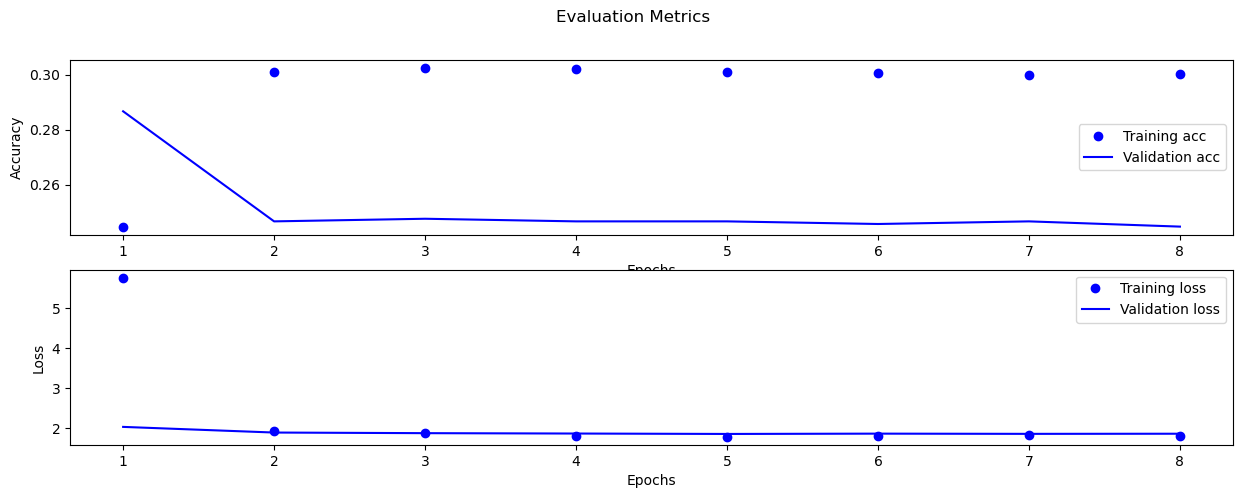

In [138]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec500)

Epoch 1/100
186/186 [==============================] - 7s 32ms/step - loss: 9.4903 - accuracy: 0.2595 - val_loss: 2.7491 - val_accuracy: 0.2838
Epoch 2/100
186/186 [==============================] - 5s 26ms/step - loss: 2.2332 - accuracy: 0.3313 - val_loss: 1.9869 - val_accuracy: 0.2771
Epoch 3/100
186/186 [==============================] - 5s 27ms/step - loss: 1.8512 - accuracy: 0.3479 - val_loss: 1.8719 - val_accuracy: 0.2962
Epoch 4/100
186/186 [==============================] - 5s 27ms/step - loss: 1.7592 - accuracy: 0.3689 - val_loss: 1.8321 - val_accuracy: 0.2943
Epoch 5/100
186/186 [==============================] - 5s 27ms/step - loss: 1.7249 - accuracy: 0.3684 - val_loss: 1.8476 - val_accuracy: 0.3171
Epoch 6/100
186/186 [==============================] - 5s 27ms/step - loss: 1.7193 - accuracy: 0.3696 - val_loss: 1.8127 - val_accuracy: 0.2962
Epoch 7/100
186/186 [==============================] - 5s 26ms/step - loss: 1.7101 - accuracy: 0.3696 - val_loss: 1.8067 - val_accuracy:

'Internal validation accuracy: 32.48%'

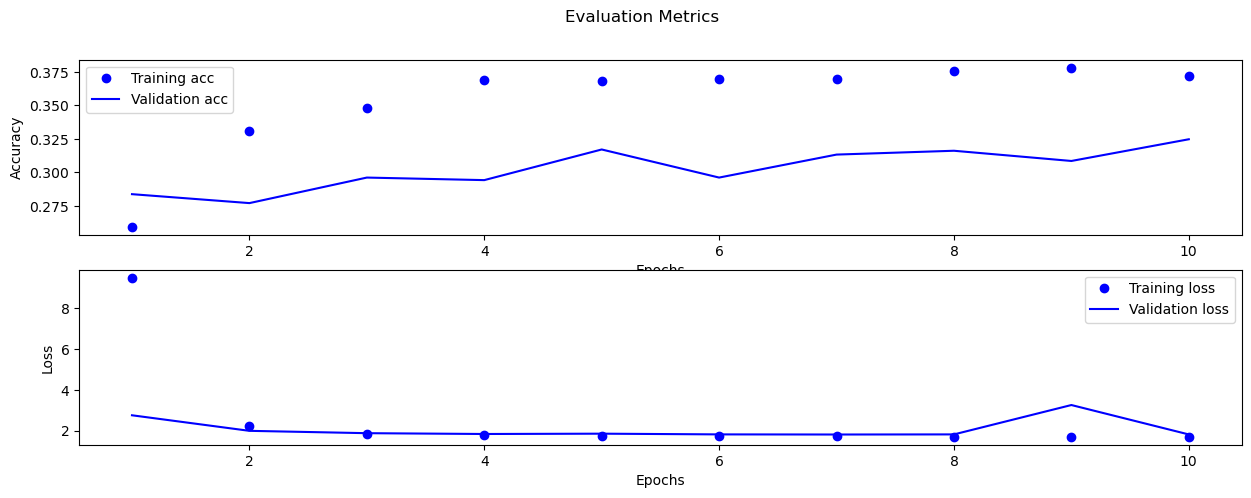

In [139]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec500)

Epoch 1/100
186/186 [==============================] - 4s 21ms/step - loss: 7.2420 - accuracy: 0.2408 - val_loss: 2.5400 - val_accuracy: 0.2933
Epoch 2/100
186/186 [==============================] - 3s 18ms/step - loss: 2.1376 - accuracy: 0.2829 - val_loss: 2.1138 - val_accuracy: 0.2133
Epoch 3/100
186/186 [==============================] - 3s 18ms/step - loss: 1.9067 - accuracy: 0.3123 - val_loss: 1.8602 - val_accuracy: 0.2438
Epoch 4/100
186/186 [==============================] - 3s 17ms/step - loss: 1.7808 - accuracy: 0.3000 - val_loss: 1.8617 - val_accuracy: 0.2467
Epoch 5/100
186/186 [==============================] - 3s 17ms/step - loss: 1.7754 - accuracy: 0.2995 - val_loss: 1.8621 - val_accuracy: 0.2457
Epoch 6/100
186/186 [==============================] - 3s 17ms/step - loss: 1.7719 - accuracy: 0.2993 - val_loss: 1.8635 - val_accuracy: 0.2467


'Internal validation accuracy: 24.67%'

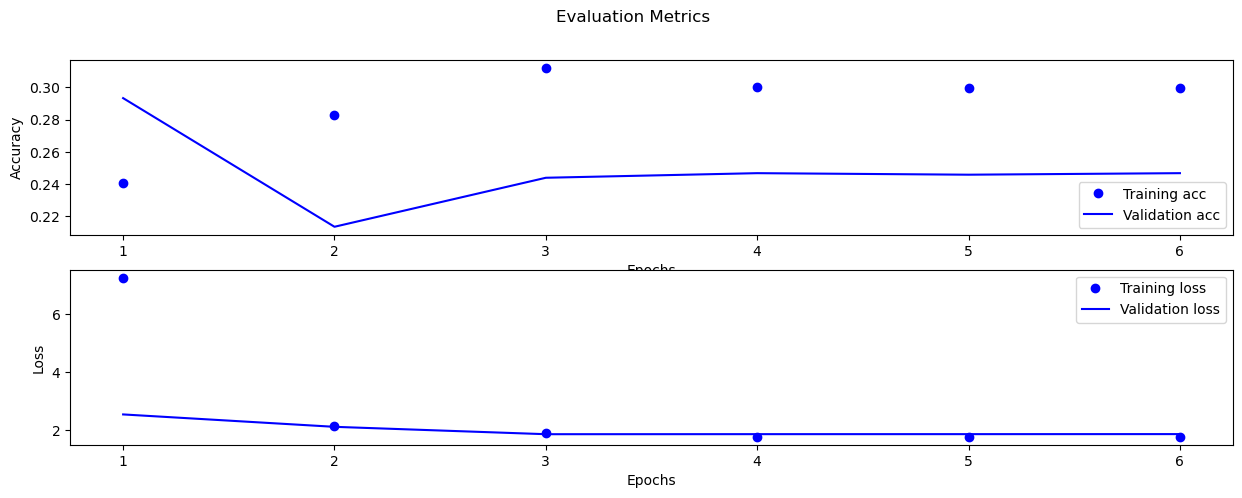

In [140]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)

Epoch 1/100
186/186 [==============================] - 6s 29ms/step - loss: 10.0918 - accuracy: 0.2597 - val_loss: 2.8322 - val_accuracy: 0.3029
Epoch 2/100
186/186 [==============================] - 5s 25ms/step - loss: 2.2848 - accuracy: 0.3271 - val_loss: 2.0587 - val_accuracy: 0.2581
Epoch 3/100
186/186 [==============================] - 5s 25ms/step - loss: 1.8683 - accuracy: 0.3435 - val_loss: 1.8533 - val_accuracy: 0.3229
Epoch 4/100
186/186 [==============================] - 5s 25ms/step - loss: 1.7649 - accuracy: 0.3666 - val_loss: 1.8312 - val_accuracy: 0.3000
Epoch 5/100
186/186 [==============================] - 5s 25ms/step - loss: 1.7488 - accuracy: 0.3674 - val_loss: 1.8503 - val_accuracy: 0.3133
Epoch 6/100
186/186 [==============================] - 5s 25ms/step - loss: 1.7268 - accuracy: 0.3761 - val_loss: 1.8208 - val_accuracy: 0.3010
Epoch 7/100
186/186 [==============================] - 5s 24ms/step - loss: 1.7079 - accuracy: 0.3748 - val_loss: 1.8713 - val_accuracy

'Internal validation accuracy: 32.76%'

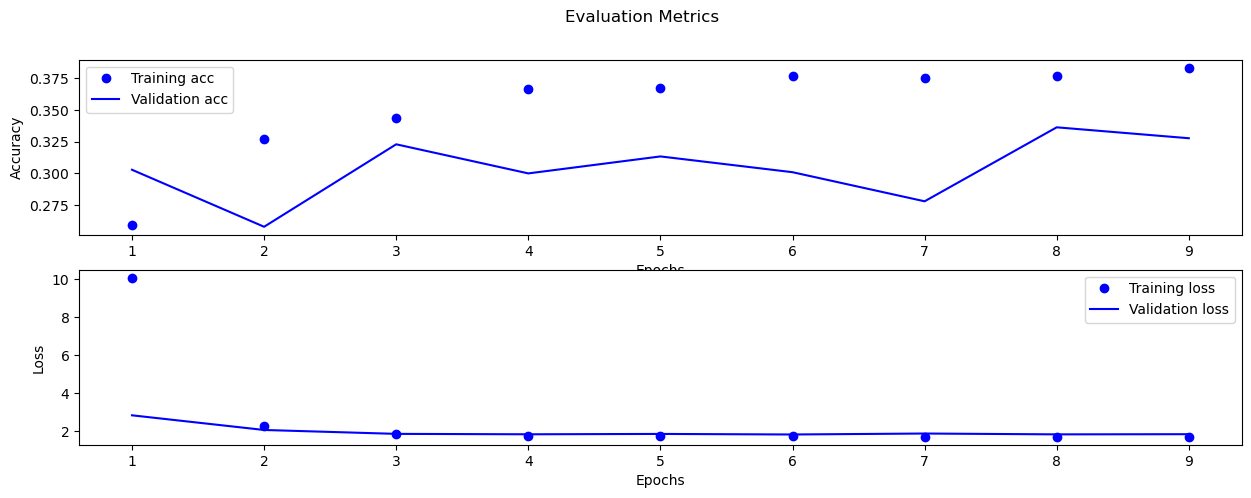

In [141]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)

### Embeddings

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 4977, 128)         637056    
                                                                 
 flatten_14 (Flatten)        (None, 637056)            0         
                                                                 
 dense_34 (Dense)            (None, 128)               81543296  
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 7)                 455       
                                                                 
Total params: 82,189,063
Trainable params: 82,189,063
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [====================

'Internal validation accuracy: 24.67%'

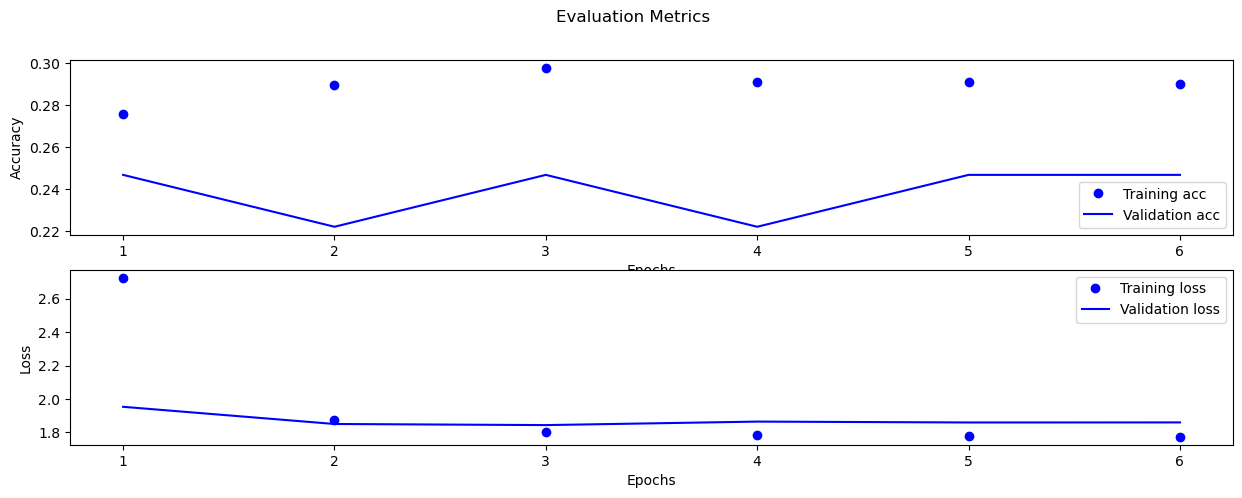

In [28]:
# define model architecture
model = Sequential([
    Embedding(4977, 128, input_shape = (4977, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vecMAX)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 1000, 128)         128000    
                                                                 
 flatten_15 (Flatten)        (None, 128000)            0         
                                                                 
 dense_37 (Dense)            (None, 128)               16384128  
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 7)                 455       
                                                                 
Total params: 16,520,839
Trainable params: 16,520,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [====================

'Internal validation accuracy: 24.67%'

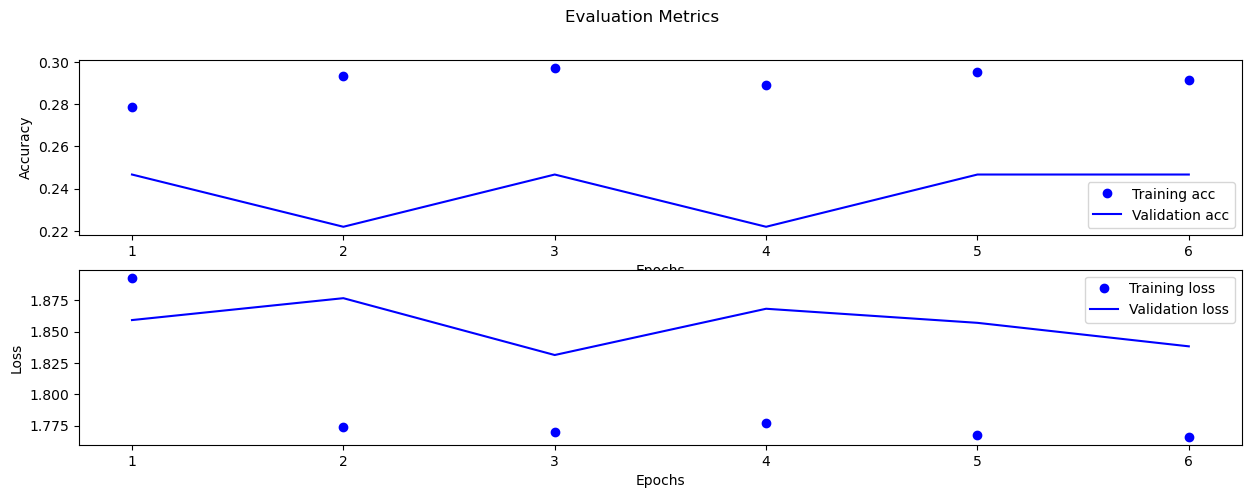

In [29]:
# define model architecture
model = Sequential([
    Embedding(1000, 128, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec1000)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 500, 128)          64000     
                                                                 
 flatten_16 (Flatten)        (None, 64000)             0         
                                                                 
 dense_40 (Dense)            (None, 128)               8192128   
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 7)                 455       
                                                                 
Total params: 8,264,839
Trainable params: 8,264,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [======================

'Internal validation accuracy: 24.67%'

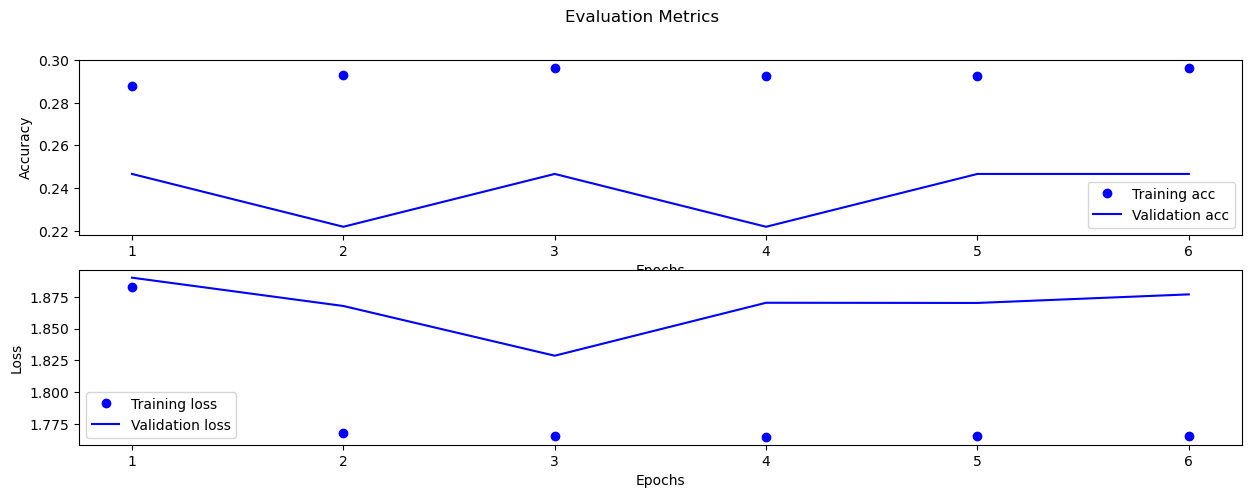

In [30]:
# define model architecture
model = Sequential([
    Embedding(500, 128, input_shape = (500, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec500)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 128)          12800     
                                                                 
 flatten_17 (Flatten)        (None, 12800)             0         
                                                                 
 dense_43 (Dense)            (None, 128)               1638528   
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 7)                 455       
                                                                 
Total params: 1,660,039
Trainable params: 1,660,039
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [======================

'Internal validation accuracy: 24.86%'

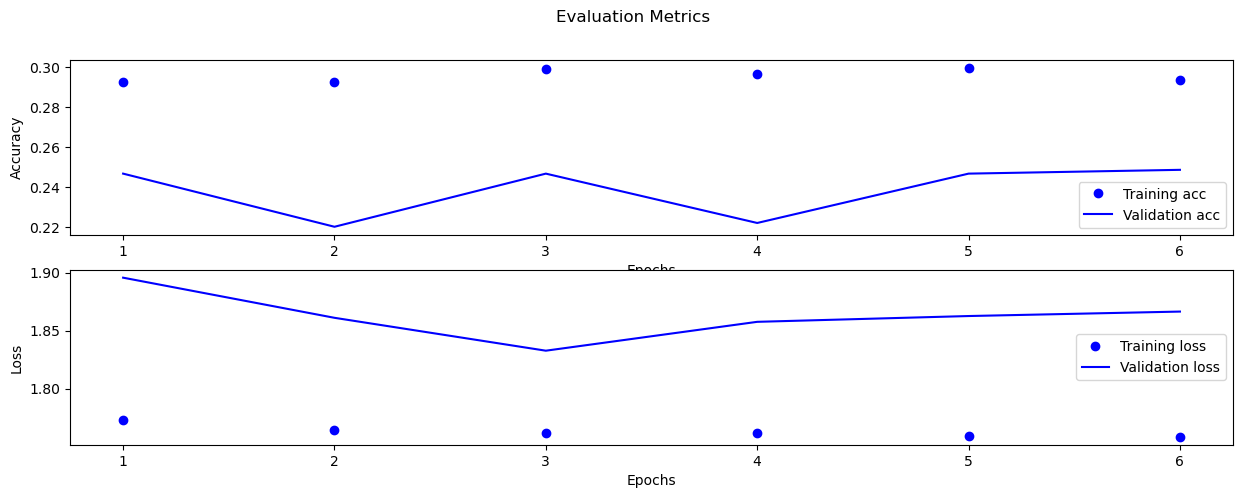

In [31]:
# define model architecture
model = Sequential([
    Embedding(100, 128, input_shape = (100, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFdoc2vec100)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 4977, 128)         637056    
                                                                 
 flatten_12 (Flatten)        (None, 637056)            0         
                                                                 
 dense_28 (Dense)            (None, 128)               81543296  
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 7)                 455       
                                                                 
Total params: 82,189,063
Trainable params: 82,189,063
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [====================

'Internal validation accuracy: 82.86%'

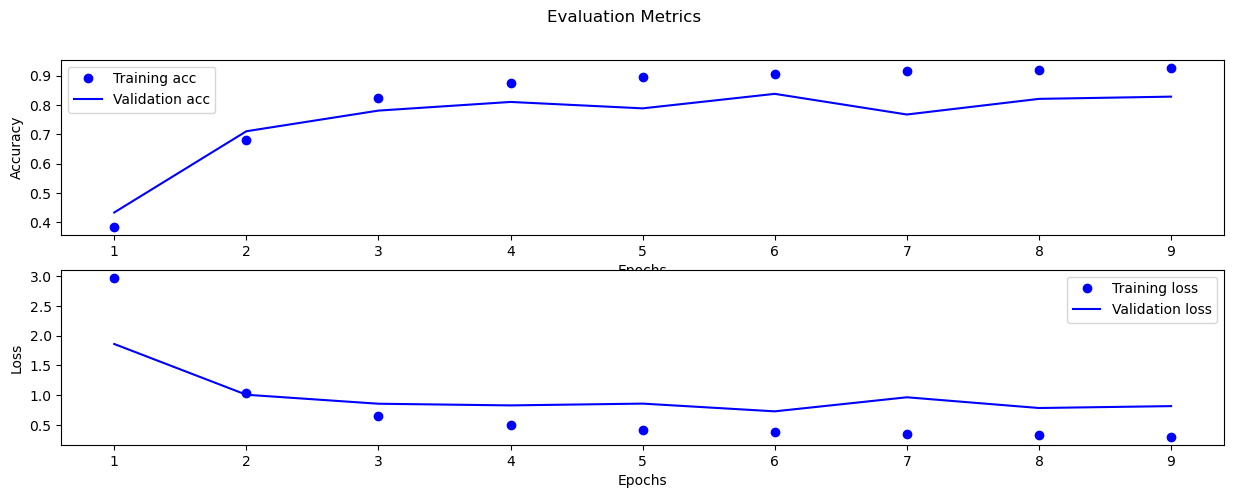

In [25]:
# define model architecture
model = Sequential([
    Embedding(4977, 128, input_shape = (4977, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVecMAX)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 128)         128000    
                                                                 
 flatten_6 (Flatten)         (None, 128000)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               16384128  
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 7)                 455       
                                                                 
Total params: 16,520,839
Trainable params: 16,520,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [=====================

'Internal validation accuracy: 83.43%'

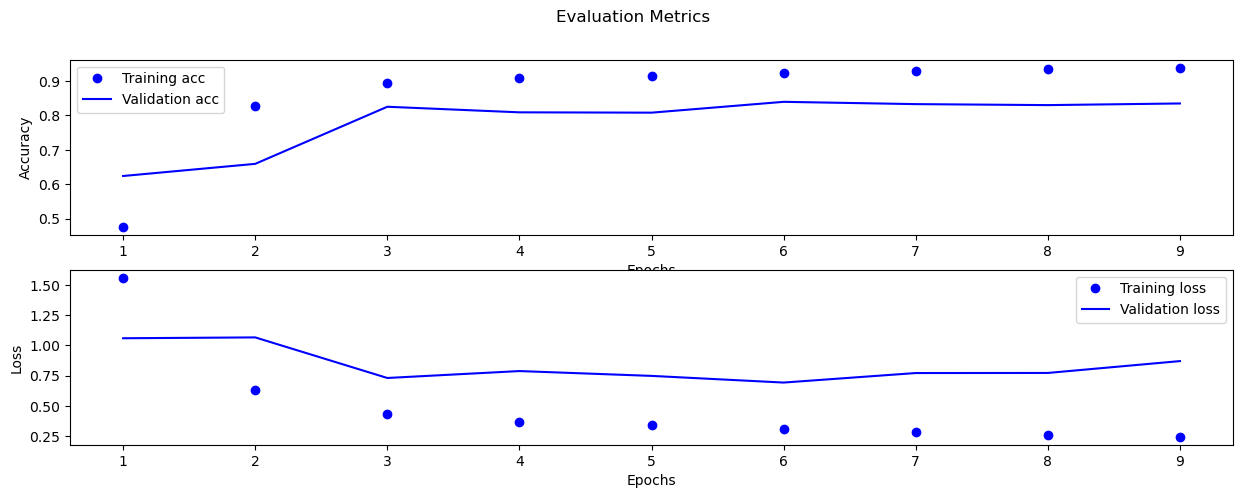

In [19]:
# define model architecture
model = Sequential([
    Embedding(1000, 128, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec1000)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 500, 128)          64000     
                                                                 
 flatten_8 (Flatten)         (None, 64000)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               8192128   
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 7)                 455       
                                                                 
Total params: 8,264,839
Trainable params: 8,264,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [=======================

'Internal validation accuracy: 24.67%'

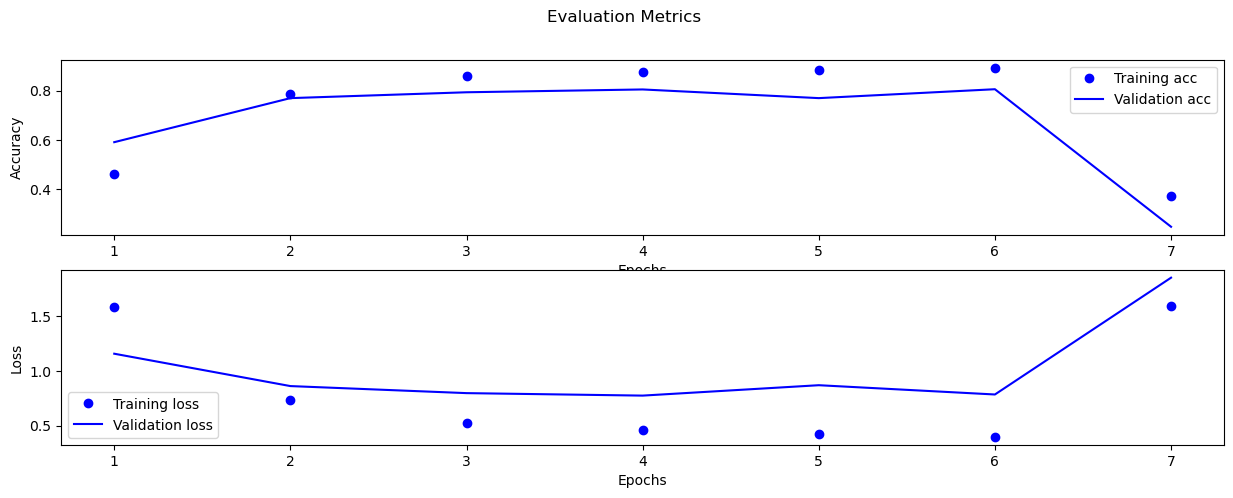

In [21]:
# define model architecture
model = Sequential([
    Embedding(500, 128, input_shape = (500, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec500)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 128)          12800     
                                                                 
 flatten_9 (Flatten)         (None, 12800)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               1638528   
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 7)                 455       
                                                                 
Total params: 1,660,039
Trainable params: 1,660,039
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
186/186 [=======================

'Internal validation accuracy: 68.67%'

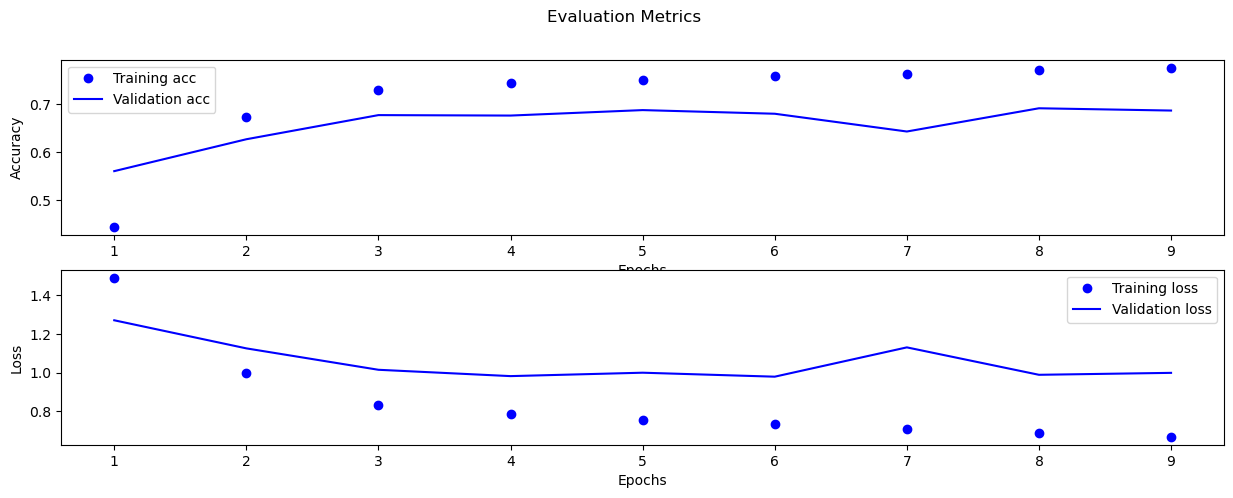

In [22]:
# define model architecture
model = Sequential([
    Embedding(100, 128, input_shape = (100, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtextVec100)